# PACE Model Replication Pipeline

**Required packages:**
- `numpy`
- `pandas`
- `pytorch`
- `imbalanced-learn`
- `scikit-learn`
- `matplotlib`

**Optional packages:**
- `ipython`
- `ipykernel`

**Required python version:** 3.9.x
We cannot use a newer version of python until pytorch adds support for it: https://github.com/pytorch/pytorch/issues/66424

**Installation commands:**

- `/path/to/conda create --name=dl4h-39 python=3.9.12`
- `conda activate dl4h-39`
- `conda install pandas pytables scipy numpy ipython ipykernel pytorch scikit-learn matplotlib`
- `conda install -c conda-forge imbalanced-learn`

## Hyperparameters

In [62]:
GAMMA = 0.5
N = 16
LAMBDA = 1.3
LR = 0.001
OMEGA = 0.001
K = 1
TOLERANCE = 0.01
PATIENCE = 2

USE_MODIFIED_LOSS_FUNCTION = False
USE_SELF_PACED_LEARNING = False

## Imports

In [63]:
import csv
import os
import pickle
import datetime

import numpy as np
import pandas as pd

from imblearn.over_sampling import RandomOverSampler

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load Data

In [65]:
def print_data_info(features, masks, labels):
    print(f"Shape of features: {features.size()}")
    print(f"Shape of masks: {masks.size()}")
    print(f"Shape of labels: {labels.size()}")
    
    print(f"Labels (format: [(label, count)]: {list(zip(*torch.unique(labels, return_counts = True)))}")

    assert len(features) == len(labels)
    assert len(masks) == len(labels)
    assert features.size() == masks.size()

In [66]:
with open("data/lvl2_train.pkl", "rb") as f:
    data = pickle.load(f).sort_values(['subject_id', 'hadm_id', 'icustay_id'])

with open("data/Ys_train.pkl", "rb") as f:
    labels = pickle.load(f).sort_values(['subject_id', 'hadm_id', 'icustay_id'])
    
data = data.reset_index(drop=True).droplevel(level="LEVEL2", axis=1)
features = data["mean"].to_numpy()
masks = data["mask"].to_numpy()

features = np.split(features, [48 * i for i in range(1, len(features) // 48)])
masks = np.split(masks, [48 * i for i in range(1, len(masks) // 48)])

features = torch.tensor(features, dtype=torch.float).to(device)
masks = torch.tensor(masks, dtype=torch.float).to(device)
labels = torch.squeeze(torch.tensor(labels.to_numpy(), dtype=torch.float).to(device))

print_data_info(features, masks, labels)

Shape of features: torch.Size([15591, 48, 104])
Shape of masks: torch.Size([15591, 48, 104])
Shape of labels: torch.Size([15591])
Labels (format: [(label, count)]: [(tensor(0.), tensor(14241)), (tensor(1.), tensor(1350))]


## Create Training, Validation and Test Splits

In [67]:
train_features, test_features, train_masks, test_masks, train_labels, test_labels = train_test_split(
    features, masks, labels, test_size=0.1, random_state=42)
train_features, val_features, train_masks, val_masks, train_labels, val_labels = train_test_split(
    train_features, train_masks, train_labels, test_size=0.1, random_state=42)

print("Training dataset")
print_data_info(train_features, train_masks, train_labels)
print("\nTest dataset")
print_data_info(test_features, test_masks, test_labels)
print("\nValidation dataset")
print_data_info(val_features, val_masks, val_labels)

Training dataset
Shape of features: torch.Size([12627, 48, 104])
Shape of masks: torch.Size([12627, 48, 104])
Shape of labels: torch.Size([12627])
Labels (format: [(label, count)]: [(tensor(0.), tensor(11531)), (tensor(1.), tensor(1096))]

Test dataset
Shape of features: torch.Size([1560, 48, 104])
Shape of masks: torch.Size([1560, 48, 104])
Shape of labels: torch.Size([1560])
Labels (format: [(label, count)]: [(tensor(0.), tensor(1431)), (tensor(1.), tensor(129))]

Validation dataset
Shape of features: torch.Size([1404, 48, 104])
Shape of masks: torch.Size([1404, 48, 104])
Shape of labels: torch.Size([1404])
Labels (format: [(label, count)]: [(tensor(0.), tensor(1279)), (tensor(1.), tensor(125))]


## Oversampling

Perform oversampling to ensure a balanced distribution of output classes

In [68]:
def oversample_data(features, masks, labels):
    X = list(zip(features, masks))
    ros = RandomOverSampler(random_state=0)
    X_resampled, labels_resampled = ros.fit_resample(X, labels)
    features_resampled, masks_resampled = list(zip(*X_resampled))

    features_resampled = np.array([np.array(xi) for xi in features_resampled])
    masks_resampled = np.array([np.array(xi) for xi in masks_resampled])

    features = torch.tensor(features_resampled, dtype=torch.float).to(device)
    masks = torch.tensor(masks_resampled, dtype=torch.float).to(device)
    labels = torch.tensor(labels_resampled, dtype=torch.float).to(device)

    return features, masks, labels

train_features, train_masks, train_labels = oversample_data(train_features, train_masks, train_labels)
print_data_info(train_features, train_masks, train_labels)

/home/iandre3/.conda/envs/mimic-extract-2/lib/python3.9/site-packages/sklearn/utils/validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
/home/iandre3/.conda/envs/mimic-extract-2/lib/python3.9/site-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray

Shape of features: torch.Size([23062, 48, 104])
Shape of masks: torch.Size([23062, 48, 104])
Shape of labels: torch.Size([23062])
Labels (format: [(label, count)]: [(tensor(0.), tensor(11531)), (tensor(1.), tensor(11531))]


## Data Loaders

### Train Data Loader

In [69]:
def pick_easy_tasks(model, x, mask, y, N, K, epoch):
    criterion = nn.BCELoss(reduction='none')
    model.train(False)
    y_hat = model(x, mask)

    # Pick tasks in the batch for which the loss is less than 1 / N.
    loss = torch.add((1 / GAMMA) * criterion(y_hat, y), -1 / N) if USE_MODIFIED_LOSS_FUNCTION else torch.add(criterion(y_hat, y), -1 / N)
    easy_indices = list((loss < 0).nonzero()) if epoch >= K else list(loss.nonzero())

    easy_timeseries = torch.empty((len(easy_indices), x.size()[1], x.size()[2]))
    easy_masks = torch.empty((len(easy_indices), x.size()[1], x.size()[2]))
    easy_labels = torch.empty((len(easy_indices),))

    for i, index in enumerate(easy_indices):
        index = index.item()
        easy_timeseries[i] = x[index]
        easy_masks[i] = mask[index]
        easy_labels[i] = y[index]

    print(f"samples picked: {len(easy_indices)}, positive samples picked: {sum(easy_labels)}, K: {K}, epoch: {epoch}")

    model.train(True)
    return torch.Tensor(easy_timeseries).to(device), torch.Tensor(easy_masks).to(device), torch.Tensor(easy_labels).to(device)

def create_easy_train_dataloader(model, N, K, epoch):
    easy_timeseries, easy_masks, easy_labels = pick_easy_tasks(model, train_features, train_masks, train_labels, N, K, epoch)
    easy_train_dataset = TensorDataset(easy_timeseries, easy_masks, easy_labels)
    if len(easy_train_dataset) == 0:
        return None, len(train_features)
    return DataLoader(easy_train_dataset, batch_size=32, shuffle=True), len(train_features)

train_dataset = TensorDataset(train_features, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Test and Validation Data Loaders

In [70]:
test_dataset = TensorDataset(test_features, test_masks, test_labels)
val_dataset = TensorDataset(val_features, val_masks, val_labels)

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

## Baseline Models

In [71]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

constant_classifier = DummyClassifier(strategy="constant", constant=1)
uniform_classifier = DummyClassifier(strategy="uniform")

inputs, labels = None, None
for inp, mask, lab in val_dataloader:
    inputs, labels = inp, lab
    labels = labels.clone().cpu().detach()

constant_classifier.fit([0] * len(labels), labels)
uniform_classifier.fit([0] * len(labels), labels)
y_constant = constant_classifier.predict([0] * len(labels))
y_uniform = uniform_classifier.predict([0] * len(labels))

print(f"Baseline F1 score constant 1: {f1_score(labels, y_constant)}")
print(f"Baseline F1 score uniform: {f1_score(labels, y_uniform)}")

Baseline F1 score constant 1: 0.1635055591890124
Baseline F1 score uniform: 0.16047904191616766


## PACE

### Model

In [72]:
import torch.nn as nn
import torch.nn.utils.rnn as rnn

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.rnn = nn.GRU(input_size=104, hidden_size=32, num_layers=1, bidirectional=False, batch_first=True)
        self.fc1 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x, mask):
        try:
            x = x * mask
        except:
            print(x, mask)
        _, h_n = self.rnn(x)
        fc1_out = self.fc1(torch.squeeze(h_n))
        r = fc1_out
        
        # Multiply prediction value before sigmoid activation by gamma.
        # This is part of the micro framework.
        if USE_MODIFIED_LOSS_FUNCTION:
            r = torch.mul(fc1_out, GAMMA)
            
        res = torch.sigmoid(r)
        return torch.squeeze(res)

tinymodel = TinyModel()
tinymodel.to(device)

print(tinymodel)

TinyModel(
  (rnn): GRU(104, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


### Loss Function

In [73]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(tinymodel.parameters(), LR)

def loss_function(y_hat, y, model):
    # Add a dimension when there is only one item in the batch.     
    if len(y_hat.size()) == 0:
        y_hat = torch.unsqueeze(y_hat, dim=0)
    
    l1 = OMEGA * sum(p.abs().sum() for p in model.parameters())
    cr = criterion(y_hat, y)
    
    return l1 + cr

def modified_loss_function(y_hat, y, model):
    # Add a dimension when there is only one item in the batch.     
    if len(y_hat.size()) == 0:
        y_hat = torch.unsqueeze(y_hat, dim=0)

    l1 = OMEGA * sum(p.abs().sum() for p in model.parameters())
    cr = (1 / GAMMA) * criterion(y_hat, y)
    
    # Calculate the loss. The regularization is just an l1 regularization with a coefficient.
    # The criterion is the binary cross-entropy multiplied by 1 / GAMMA, a part of the micro framework.
    return l1 + cr

    # The paper also says to subtract batch_size / N, but this value is different for different batches depending
    # on the number of easy tasks in the batch, making it hard to compare loss across batches. Crucially, this 
    # is confusing when you look at the loss on training data (non-full batches) vs loss on testing data (full-size batches).
    # This makes me think that actually the paper meant that you first pick easy tasks across the entire testing set,
    # and then split it into batches rather than split into batches first and pick easy tasks after.
    # batch_size = y_hat.size()[0]    
    # neg = batch_size / N
    # return l1 + cr - neg

### Training

In [74]:
previous_loss = 1e10
previous_state_dict = None
optimistic_iters = 0

for epoch in range(100):
    print(f"\n\nN is set to {N}")
    running_loss = 0.0
    number_examples_used = 0
    dataloader, max_num_examples = create_easy_train_dataloader(tinymodel, N, K, epoch) if USE_SELF_PACED_LEARNING else (train_dataloader, len(train_dataset))
    
    if dataloader is not None:
        for i, (features, masks, labels) in enumerate(dataloader):
            tinymodel.train(True)
            optimizer.zero_grad()

            # Train on easy sequences.
            output = tinymodel(features, masks)
            loss = modified_loss_function(output, labels, tinymodel) if USE_MODIFIED_LOSS_FUNCTION else loss_function(output, labels, tinymodel)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            number_examples_used += len(features)
            if (i + 1) % 100 == 0:
                print(f'Epoch: [{epoch + 1}, training batch {i + 1:5d}] running training loss: {(running_loss / 100):.3f}')
                running_loss = 0.0
    
    tinymodel.train(False)
    print(f"In epoch {epoch + 1}, number of examples trained on is {number_examples_used} out of {max_num_examples}")

    running_val_loss = 0.0
    for i, (val_inputs, val_masks, val_labels) in enumerate(val_dataloader):
        val_outputs = tinymodel(val_inputs, val_masks)
        val_loss = modified_loss_function(output, labels, tinymodel) if USE_MODIFIED_LOSS_FUNCTION else loss_function(output, labels, tinymodel)
        running_val_loss += val_loss.item()
    
    normalized_running_val_loss = running_val_loss / len(val_dataloader)
    print(f"Validation loss: {normalized_running_val_loss:.3f}")
    
    if previous_loss - normalized_running_val_loss < TOLERANCE and epoch > 25 and previous_state_dict is not None:
        if optimistic_iters < PATIENCE:
            print("Being patient")
            optimistic_iters += 1
        else:
            print(f"Early stopping, as {previous_loss - normalized_running_val_loss} < {TOLERANCE}")
            tinymodel.load_state_dict(previous_state_dict)
            break
    else:
        previous_loss = normalized_running_val_loss
        previous_state_dict = tinymodel.state_dict()
        optimistic_iters = 0
    
    # Once we have passed K warm-up epochs, decrease N by a factor of lambd
    # and as such increase 1 / N, so increase the loss threshold that defines
    # what tasks are considrered easy.
    if epoch >= K:
        N = N / LAMBDA

print("\n\nFinished Training")



N is set to 16
Epoch: [1, training batch   100] running training loss: 1.340
Epoch: [1, training batch   200] running training loss: 0.717
Epoch: [1, training batch   300] running training loss: 0.592
Epoch: [1, training batch   400] running training loss: 0.586
Epoch: [1, training batch   500] running training loss: 0.556
Epoch: [1, training batch   600] running training loss: 0.550
Epoch: [1, training batch   700] running training loss: 0.537
In epoch 1, number of examples trained on is 23062 out of 23062
Validation loss: 0.588


N is set to 16
Epoch: [2, training batch   100] running training loss: 0.531
Epoch: [2, training batch   200] running training loss: 0.526
Epoch: [2, training batch   300] running training loss: 0.545
Epoch: [2, training batch   400] running training loss: 0.534
Epoch: [2, training batch   500] running training loss: 0.535
Epoch: [2, training batch   600] running training loss: 0.509
Epoch: [2, training batch   700] running training loss: 0.524
In epoch 2,

KeyboardInterrupt: 

### Save Trained Model to Disk

In [ ]:
enabled_features = []
if USE_MODIFIED_LOSS_FUNCTION:
    enabled_features.append("modified_loss")
if USE_SELF_PACED_LEARNING:
    enabled_features.append("spl")

features_string = '_and_'.join(enabled_features)

model_name = f"model_with_{features_string}.pt" if len(features_string) > 0 else "base_model.pt"

torch.save(tinymodel.state_dict(), model_name)

## PACE Metrics

F1 score: 0.40772532188841204
ROC AUC: 0.7836607998959907


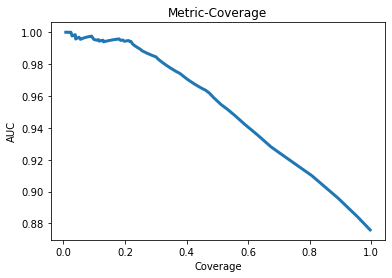

Area under the metric-coverage plot: 0.9523113756362374


In [75]:
tinymodel.train(False)

out = None
lab = None
for inputs, masks, labels in test_dataloader:
    outputs = tinymodel(inputs, masks)
    out = outputs
    outputs = outputs > 0.5
    lab = labels
    labels = labels.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    print(f"F1 score: {f1_score(labels, outputs)}")
    print(f"ROC AUC: {roc_auc_score(labels, outputs)}")

def mean(x):
    return sum(x) / len(x)

coverages = []
calculated_metrics = []
    
AUC = 0
confidences = 0.5 + abs(out - 0.5)
ordered_indices = torch.argsort(confidences, descending=True)
ordered_outputs = torch.index_select(out, 0, ordered_indices)
ordered_labels = torch.index_select(lab, 0, ordered_indices)

for confidence_threshold in np.arange(0.99, 0.01, -0.01):
    above_confidence_threshold_indices = torch.nonzero(ordered_outputs[ordered_outputs > confidence_threshold]).squeeze()
    above_confidence_outputs = torch.index_select(ordered_outputs, 0, above_confidence_threshold_indices)
    above_confidence_labels = torch.index_select(ordered_labels, 0, above_confidence_threshold_indices)
    
    if torch.sum(above_confidence_labels) == 0 or torch.sum(above_confidence_outputs) == 0:
        continue
    if torch.sum(above_confidence_labels) == len(above_confidence_labels) or torch.sum(above_confidence_outputs) == len(above_confidence_outputs):
        continue

    metric = roc_auc_score(above_confidence_labels.cpu().detach().numpy(), above_confidence_outputs.cpu().detach().numpy())
    calculated_metrics.append(metric)
    coverage = len(above_confidence_outputs) / len(ordered_outputs)
    coverages.append(coverage)
    
    AUC += metric * 0.01
    
fig, ax = plt.subplots()
# ax.set_linewidths([3])
ax.plot(coverages, calculated_metrics, linewidth=3)
ax.set_title('Metric-Coverage')
ax.set_xlabel('Coverage')
ax.set_ylabel('AUC')
plt.show()
print(f"Area under the metric-coverage plot: {AUC}")

## Loading the state dict

In [ ]:
model_state_dict = torch.load('model.pt')
new_model = TinyModel()
new_model.load_state_dict(model_state_dict)